# Paleo-Detector Analysis Pipeline
 
This notebook provides a complete, end-to-end workflow for the phenomenological analysis of paleo-detectors. It calculates the expected nuclear recoil track spectra from both cosmic ray muon signals and internal backgrounds.
 
**Workflow:**
1.  **Configuration:** All analysis parameters are set in the configuration cell below. This includes selecting the mineral, defining astrophysical scenarios, and setting geological parameters.
2.  **Initialization:** A `Mineral` object is created using the refactored `mineral_utils.py` module. This object handles all low-level data loading and physics calculations.
3.  **Background Calculation:** The notebook calculates the track spectrum from the primary internal background: spontaneous fission of Uranium-238.
4.  **Signal Calculation:** For each defined astrophysical scenario, it calculates the track spectrum from cosmic ray muons, including a model for continuous overburden deposition.
5.  **Analysis & Plotting:** The final results are combined, plotted, and the statistical significance between scenarios is calculated.


In [1]:
# --- Core Libraries ---
import numpy as np
from matplotlib import pyplot as plt
import os

# --- Custom Utility Module ---
# Ensure mineral_utils.py is in the same directory or in your Python path
import mineral_utils as mu

print("Libraries imported successfully.")

Libraries imported successfully.


In [8]:
CONFIG = {
    # --- Mineral and File Configuration ---
    "mineral_name": "Halite",  # Must match a key in MINERAL_LIBRARY below
    
    # --- Geological & Sample Parameters ---
    "sample_mass_kg": 0.01,       # Sample mass in kg (e.g., 0.01 for 10g)
    "total_age_myr": 5.9,         # Total age of the sample in millions of years
    "exposure_window_myr": 0.6,  # Duration of CR signal exposure in Myr

    # --- Continuous Deposition Model Parameters ---
    # Rate of overburden deposition in meters per thousand years (m/kyr).
    # SET TO 0 for a simple surface exposure with no continuous shielding.
    "deposition_rate_m_kyr": 0., 
    "overburden_density_g_cm3": 2.16,
    "initial_depth_m": 0.,

    # --- Astrophysical Scenarios ---
    # Dictionary mapping plot labels to the scenario tag names used in file lookups.
    "scenarios": {
        "Scenario 0": "Resconi",
        
        "Scenario A (SN @ 20pc)": "SN20pcGCR",
        
        "Scenario B (SN @ 50pc)": "SN50pcGCR",
        
        "Scenario C (SN @ 100pc)": "SN100pcGCR"
    },

    # --- Plotting & Binning Configuration ---
    "n_bins": 50,
    "x_min_log_nm": 3., # Min track length in log10(nm)
    "x_max_log_nm": 5., # Max track length in log10(nm)

    # Parameters derived from Geant4 simulation setup
    "geant4_energy_names_gev": ["1.166000", "1.555000", "2.074000", "2.766000", "3.689000",
                                "4.920000", "6.560000", "8.740000", "11.190000", "13.880000",
                                "17.210000", "21.330000", "26.440000", "32.780000", "40.640000",
                                "50.120000", "61.530000", "75.540000", "92.740000", "113.860000",
                                "139.780000", "171.610000", "210.600000", "258.600000", "317.500000",
                                "392.700000", "488.600000", "607.900000", "756.300000", "941.000000",
                                "1170.700000", "1456.500000", "1812.200000", "2254.600000"],
    "geant4_energy_bins_gev": [1.0, 1.33, 1.78, 2.37, 3.16, 4.22, 5.62, 7.5, 10.0, 12.6, 15.8, 20.0,
                               25.1, 31.6, 39.8, 50.1, 63.1, 79.4, 100.0, 126, 158, 200, 251, 316,
                               398, 501, 631, 794, 1000, 1260, 1580, 2000, 2510, 3160, 3980],

    "mineral_target_thickness_cm": 1000, # Thickness of the target in the Geant4 simulation in cm
    "total_simulated_muons": 1e4,        # Number of muons simulated in each Geant4 run, for weighting
}

In [9]:
# Define the track length bins for the analysis
x_bins = np.logspace(CONFIG['x_min_log_nm'], CONFIG['x_max_log_nm'], CONFIG['n_bins'])
x_mid = x_bins[:-1] + np.diff(x_bins) / 2.0

In [10]:
# --- Mineral Library ---
# To analyze a new mineral, add its properties here and ensure the
# corresponding SRIM and Geant4 data files exist in the Data/ directory.
MINERAL_LIBRARY = {
    "Halite": {
        "name": "Halite",
        "shortname": "Hal",
        "composition": "Na-Cl",
        "nuclei": ["Na", "Cl"],
        "target_nuclei_geant4": ["Cl35", "Cl37", "Na23", "Nuclei"],
        "nuclei_z": {"Na": 11, "Cl": 17},
        "stoich": [1, 1],
        "atomic_mass": {"Na": 22.99, "Cl": 35.45},
        "fragments": ['S', 'Ne', 'O', 'Si', 'Al', 'P', 'F', 'N', 'C', 'Mg', 'Na', 'He', 'B', 'Be', 'Cl', 'Ar', 'Li'],
        "uranium_concentration_g_g": 5e-8,
        "density_g_cm3": 2.16,
    },
    "Olivine": {
        "name": "Olivine",
        "nuclei": ["Mg", "Fe", "Si", "O"],
        "nuclei_z": {"Mg": 12, "Fe": 26, "Si": 14, "O": 8},
        "stoich": [1.6, 0.4, 1, 4],
        "atomic_mass": {"Mg": 24.31, "Fe": 55.85, "Si": 28.09, "O": 16.00},
        "fragments": [], # Add fragment list for Olivine if needed
        "uranium_concentration_g_g": 0.1e-9,
    }

}

In [11]:
# --- Setup & Verification ---
mineral_config = MINERAL_LIBRARY.get(CONFIG["mineral_name"])
if not mineral_config:
    raise ValueError(f"Mineral '{CONFIG['mineral_name']}' not found in MINERAL_LIBRARY.")

mineral = mu.Mineral(mineral_config)

Initialized Mineral: Halite


In [12]:
# Calculate the fission track rate using the utility function
drdx_fission = mineral.calculate_fission_spectrum(x_bins)

# Calculate the total number of fission tracks expected over the sample's age
total_fission_tracks = drdx_fission * CONFIG['total_age_myr'] * CONFIG['sample_mass_kg']

print("Background calculation complete.")

Calculating spontaneous fission background...
Loading pre-processed SRIM data for Rb (Z=37) from Data/SRIM_data/Halite/Rb-Hal.txt
Loading pre-processed SRIM data for Cs (Z=55) from Data/SRIM_data/Halite/Cs-Hal.txt
Loading pre-processed SRIM data for Sr (Z=38) from Data/SRIM_data/Halite/Sr-Hal.txt
Loading pre-processed SRIM data for Xe (Z=54) from Data/SRIM_data/Halite/Xe-Hal.txt
Loading pre-processed SRIM data for Zr (Z=40) from Data/SRIM_data/Halite/Zr-Hal.txt
Loading pre-processed SRIM data for Te (Z=52) from Data/SRIM_data/Halite/Te-Hal.txt
Loading pre-processed SRIM data for Br (Z=35) from Data/SRIM_data/Halite/Br-Hal.txt
Loading pre-processed SRIM data for La (Z=57) from Data/SRIM_data/Halite/La-Hal.txt
Loading pre-processed SRIM data for Nb (Z=41) from Data/SRIM_data/Halite/Nb-Hal.txt
Loading pre-processed SRIM data for Sb (Z=51) from Data/SRIM_data/Halite/Sb-Hal.txt
Loading pre-processed SRIM data for Kr (Z=36) from Data/SRIM_data/Halite/Kr-Hal.txt
Loading pre-processed SRIM dat

  - Processing timestep: 0.0 kyr
Loading pre-processed SRIM data for S (Z=16) from Data/SRIM_data/Halite/S-Hal.txt
Loading pre-processed SRIM data for Ne (Z=10) from Data/SRIM_data/Halite/Ne-Hal.txt
Loading pre-processed SRIM data for O (Z=8) from Data/SRIM_data/Halite/O-Hal.txt
Loading pre-processed SRIM data for Si (Z=14) from Data/SRIM_data/Halite/Si-Hal.txt
Loading pre-processed SRIM data for Al (Z=13) from Data/SRIM_data/Halite/Al-Hal.txt
Loading pre-processed SRIM data for P (Z=15) from Data/SRIM_data/Halite/P-Hal.txt
Loading pre-processed SRIM data for F (Z=9) from Data/SRIM_data/Halite/F-Hal.txt
Loading pre-processed SRIM data for N (Z=7) from Data/SRIM_data/Halite/N-Hal.txt
Loading pre-processed SRIM data for C (Z=6) from Data/SRIM_data/Halite/C-Hal.txt
Loading pre-processed SRIM data for Mg (Z=12) from Data/SRIM_data/Halite/Mg-Hal.txt
Loading pre-processed SRIM data for Na (Z=11) from Data/SRIM_data/Halite/Na-Hal.txt
Loading pre-processed SRIM data for B (Z=5) from Data/SRIM_

/home/cgalelli/miniconda3/envs/crpropa/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


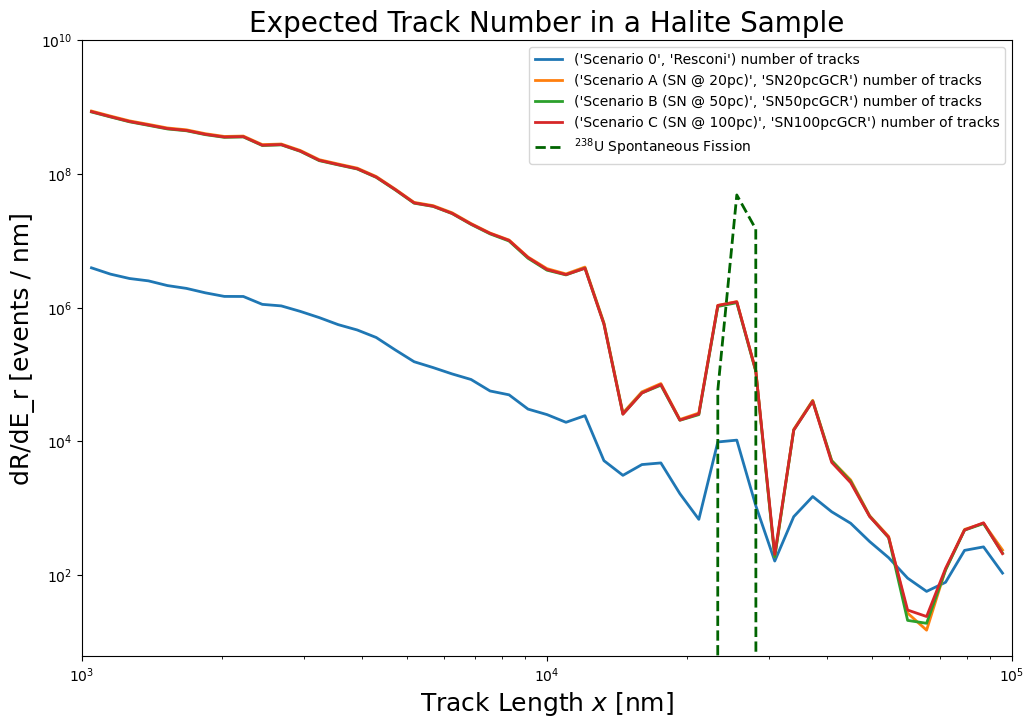

In [13]:
plt.figure(figsize=(12, 8))

for scenario in CONFIG["scenarios"].items():
    integrated_scenario = mineral.integrate_muon_signal_spectrum(
            x_bins=x_bins,
            scenario=scenario,
            energy_names_gev=CONFIG["geant4_energy_names_gev"],
            energy_bins_gev=CONFIG["geant4_energy_bins_gev"],
            exposure_window_myr=CONFIG["exposure_window_myr"],
            sample_mass_kg=CONFIG["sample_mass_kg"],
            target_thickness_cm=CONFIG["mineral_target_thickness_cm"],
            initial_depth=CONFIG["initial_depth_m"],
            deposition_rate_m_kyr=CONFIG["deposition_rate_m_kyr"],
            overburden_density_g_cm3=CONFIG["overburden_density_g_cm3"],
            total_simulated_muons=CONFIG["total_simulated_muons"]
        )
    
    plt.plot(x_mid, integrated_scenario, linewidth=2, label=f'{scenario} number of tracks')

plt.plot(x_mid, total_fission_tracks, color="darkgreen", linestyle="--", linewidth=2, label=r'$^{238}$U Spontaneous Fission')
plt.title(f"Expected Track Number in a {CONFIG['mineral_name']} Sample", fontsize=20)
plt.ylabel(r"dR/dE_r [events / nm]", fontsize=18)
plt.xlabel(r"Track Length $x$ [nm]", fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**CONFIG['x_min_log_nm'], 10**CONFIG['x_max_log_nm'])
plt.ylim(0,1e10)
plt.legend(fontsize=10)
plt.show()
    